<a href="https://colab.research.google.com/github/conwayjw97/Image-Colourisation/blob/master/src/CGANCelebFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Variables

In [0]:
IMAGE_COUNT = 50000
TRAINING_IMAGE = 0
TEST_IMAGE = 0
BATCH_SIZE = 1000
TRAINING_EPOCHS = 400
LOAD_COLOURISATION_MODEL = False
INPUT_IMAGE = 5

# Import Statements

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from skimage import io
from skimage.transform import resize
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import datasets, layers, models, backend, utils, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive, files

drive.mount("/content/gdrive", force_remount=True)
base_dir = "/content/gdrive/My Drive/Neural Network Models/"

Mounted at /content/gdrive


# Load Dataset

In [0]:
# This repository uses a handy cropped celebrity dataset
# !git clone https://github.com/2014mchidamb/DeepColorization/

images = train_images = test_images = []
for image in io.imread_collection('DeepColorization/face_images/*.jpg'): 
  images.append(resize(image, (128, 128)))
  
train_images = np.array(images)[0:-1:2,:,:,:IMAGE_COUNT]
test_images = np.array(images)[1::2,:,:,:IMAGE_COUNT]

# Convert Colourisation Images to YUV

In [0]:
# Outputs a tensor of the same shape as the images tensor, containing the YUV 
# value of the pixels. The output is only well defined if the value in images 
# are in [0,1].
#https://zhengtq.github.io/2018/12/27/tensorflow-disturb-yuv/

train_yuvImages = tf.image.rgb_to_yuv(train_images[:IMAGE_COUNT])
train_y = tf.expand_dims(train_yuvImages[:,:,:,0], 3)
train_uv = train_yuvImages[:,:,:,1:]

test_yuvImages = tf.image.rgb_to_yuv(test_images[:IMAGE_COUNT])
test_y = tf.expand_dims(test_yuvImages[:,:,:,0], 3)
test_uv = test_yuvImages[:,:,:,1:]

# Create the Colourisation GAN

In [13]:
class GAN():
    def __init__(self):
        optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        y_image = layers.Input(shape=(128, 128, 1))
        uv_image = self.generator(y_image)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        validity = self.discriminator(uv_image)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = models.Model(y_image, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        self.gen_loss_history = []
        self.disc_loss_history = []
        self.disc_acc_history = []

    def build_generator(self):

        model = models.Sequential()

        model.add(layers.Conv2D(8, (3, 3), input_shape=(128, 128, 1)))
        model.add(layers.LeakyReLU())
        model.add(layers.Conv2D(16, (3, 3), padding='same', strides=2))
        model.add(layers.LeakyReLU())
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(32, (3, 3), padding='same', strides=2))
        model.add(layers.LeakyReLU())
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(128, (3, 3), padding='same', strides=2))
        model.add(layers.LeakyReLU())
        model.add(layers.UpSampling2D((2, 2)))
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(128, (3, 3), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.UpSampling2D((2, 2)))
        model.add(layers.Conv2D(32, (3, 3), padding='same'))
        model.add(layers.LeakyReLU())
        # model.add(layers.Dropout(0.2))
        model.add(layers.BatchNormalization(momentum=0.8))
        model.add(layers.Conv2D(16, (3, 3), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.UpSampling2D((2, 2)))
        model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))

        y_image = layers.Input(shape=(128, 128, 1))
        uv_image = model(y_image)

        return models.Model(y_image, uv_image)

    def build_discriminator(self):

        model = models.Sequential()

        model.add(layers.Conv2D(16, (5, 5), strides=(2, 2), padding='same', input_shape=[128, 128, 2]))
        model.add(layers.LeakyReLU())
        model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
        model.add(layers.LeakyReLU())
        model.add(layers.Flatten())
        model.add(layers.Dense(1, activation='sigmoid'))

        img = layers.Input(shape=(128, 128, 2))
        validity = model(img)

        return models.Model(img, validity)

    def train(self, epochs, y_images, uv_images, save_interval=20):
        # Split the dataset into batches
        # batched_train_y = np.array(np.split(train_y, (train_y.shape[0]/BATCH_SIZE)))
        # batched_train_uv = np.array(np.split(train_uv, (train_uv.shape[0]/BATCH_SIZE)))

        self.gen_loss_history = []
        self.disc_loss_history = []
        self.disc_acc_history = []

        time_total = 0

        datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

        for epoch in range(1, epochs+1):
            start = time.time()

            batches = 0

            for y_batch, uv_batch in datagen.flow(y_images, uv_images, batch_size=len(y_images)):

              # ---------------------
              #  Train Discriminator
              # ---------------------

              # Generate a batch of new images
              gen_imgs = self.generator.predict(y_batch)

              # Train the discriminator
              d_loss_real = self.discriminator.train_on_batch(uv_batch, np.ones((uv_batch.shape[0], 1)))
              d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((gen_imgs.shape[0], 1)))
              d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

              # ---------------------
              #  Train Generator
              # ---------------------

              # The generator wants the discriminator to label the generated samples
              # as valid (ones)
              valid_y = np.array([1] * gen_imgs.shape[0])

              # Train the generator
              g_loss = self.combined.train_on_batch(y_batch, valid_y)

              batches += 1
              if batches >= len(y_images) / BATCH_SIZE:
                  # we need to break the loop by hand because
                  # the generator loops indefinitely
                  break

            # Print the progress
            # Add a time left predictor
            time_total += time.time()-start
            print("Epoch %d/%d - Time %.2fs - Estimated time left %ds - Discriminator loss: %f, acc.: %.2f%% - Generator loss: %f" % (epoch, epochs, time.time()-start, (time_total/epoch)*(epochs-epoch), d_loss[0], 100*d_loss[1], g_loss))
            self.gen_loss_history.append(g_loss)
            self.disc_loss_history.append(d_loss[0])
            self.disc_acc_history.append(100*d_loss[1])

            # If at save interval, save the generator model
            if epoch % save_interval == 0:
              model_json = self.generator.to_json()
              with open(base_dir + "celebfaces_gan_generator.json", "w+") as json_file:
                json_file.write(model_json)
              self.generator.save_weights(base_dir + "celebfaces_gan_generator.h5")
              print("Saved model to disk")

    def generate_uv_images(self, y_images):
      return self.generator.predict(y_images)

    def get_training_metrics(self):
      return self.gen_loss_history, self.disc_loss_history, self.disc_acc_history


gan = GAN()
gan.train(TRAINING_EPOCHS, train_y, train_uv)

Epoch 1/400 - Time 9.02s - Estimated time left 3597s - Discriminator loss: 0.692749, acc.: 50.00% - Generator loss: 0.666406
Epoch 2/400 - Time 1.04s - Estimated time left 2000s - Discriminator loss: 0.681978, acc.: 100.00% - Generator loss: 0.645142
Epoch 3/400 - Time 1.02s - Estimated time left 1464s - Discriminator loss: 0.646881, acc.: 100.00% - Generator loss: 0.584552
Epoch 4/400 - Time 0.97s - Estimated time left 1191s - Discriminator loss: 0.604359, acc.: 100.00% - Generator loss: 0.495067
Epoch 5/400 - Time 1.02s - Estimated time left 1031s - Discriminator loss: 0.753429, acc.: 50.13% - Generator loss: 0.328884
Epoch 6/400 - Time 0.97s - Estimated time left 920s - Discriminator loss: 0.792035, acc.: 50.00% - Generator loss: 0.332049
Epoch 7/400 - Time 1.01s - Estimated time left 843s - Discriminator loss: 0.683148, acc.: 54.40% - Generator loss: 0.487185
Epoch 8/400 - Time 0.97s - Estimated time left 784s - Discriminator loss: 0.610125, acc.: 99.73% - Generator loss: 0.630853


# Diagnostic Learning Curve

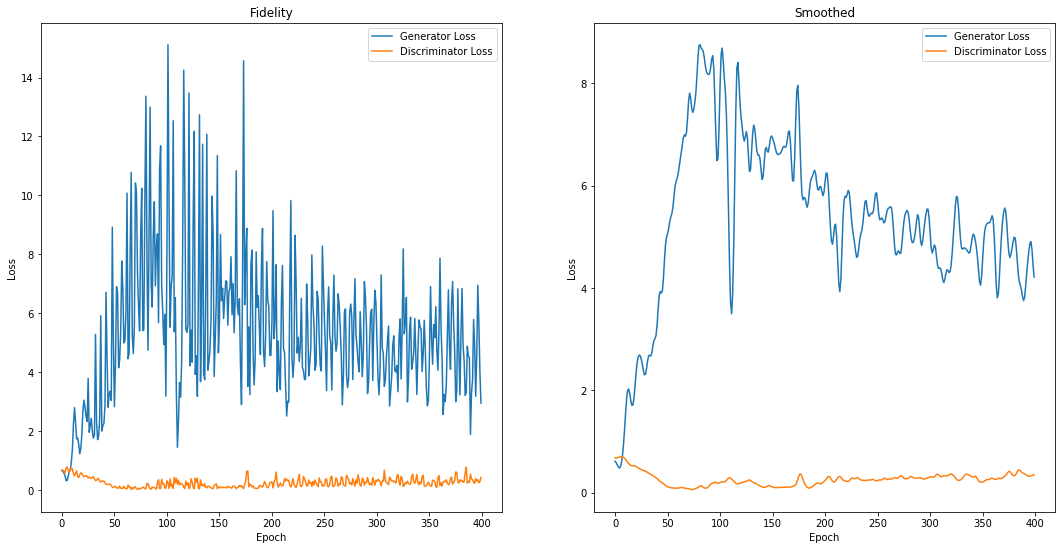

In [14]:
gen_loss_history, disc_loss_history, disc_acc_history = gan.get_training_metrics()

fig = plt.figure(figsize=(38, 9))

fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(gen_loss_history, label="Generator Loss")
plt.plot(disc_loss_history, label="Discriminator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Fidelity.png")
# files.download("Fidelity.png") 

fig.add_subplot(1,4,2)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(gen_loss_history, sigma=2), label="Generator Loss")
plt.plot(gaussian_filter1d(disc_loss_history, sigma=2), label="Discriminator Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Smooted.png")
# files.download("Smooted.png") 

# Training Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

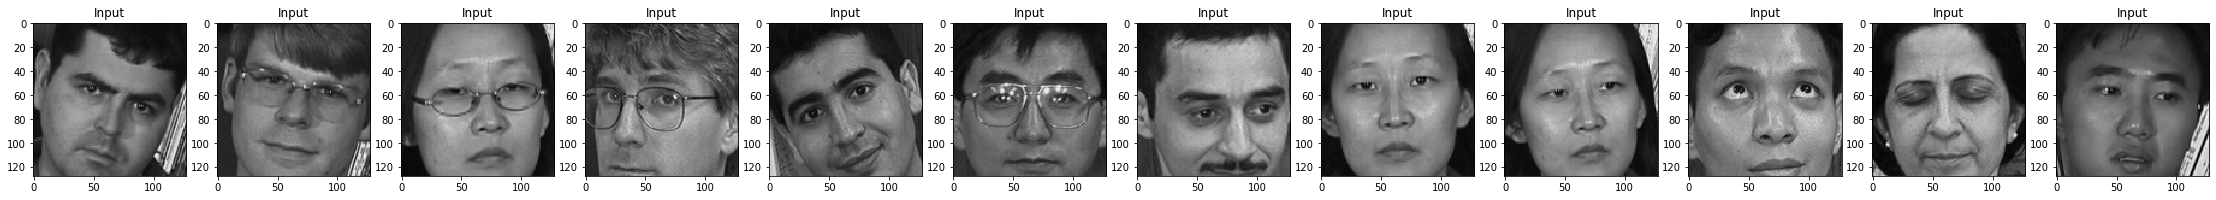

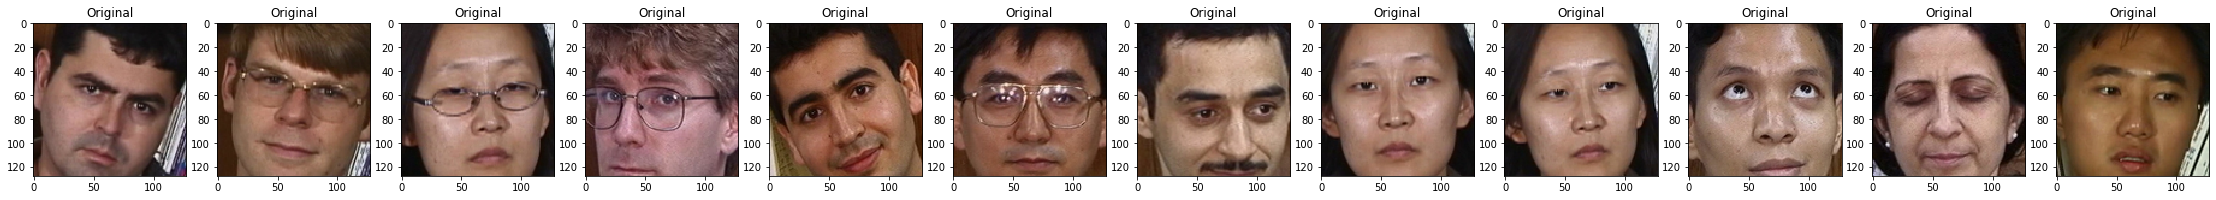

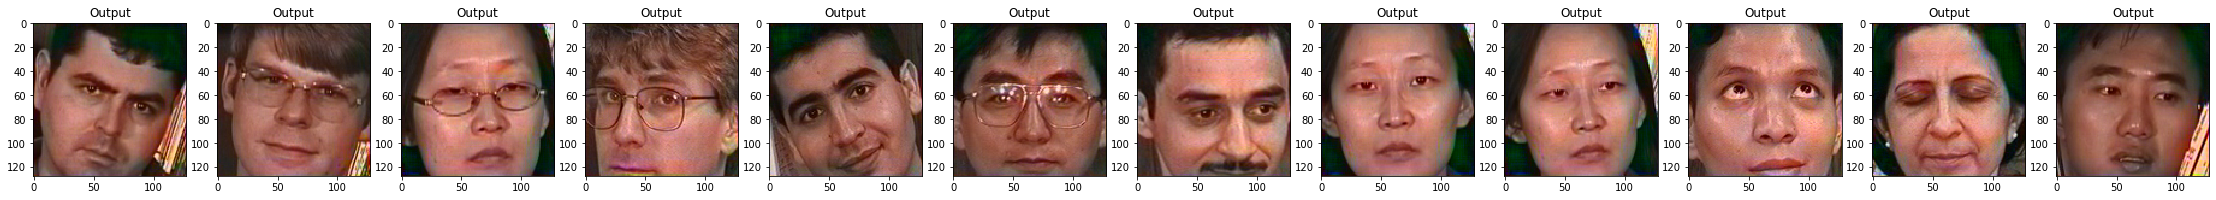

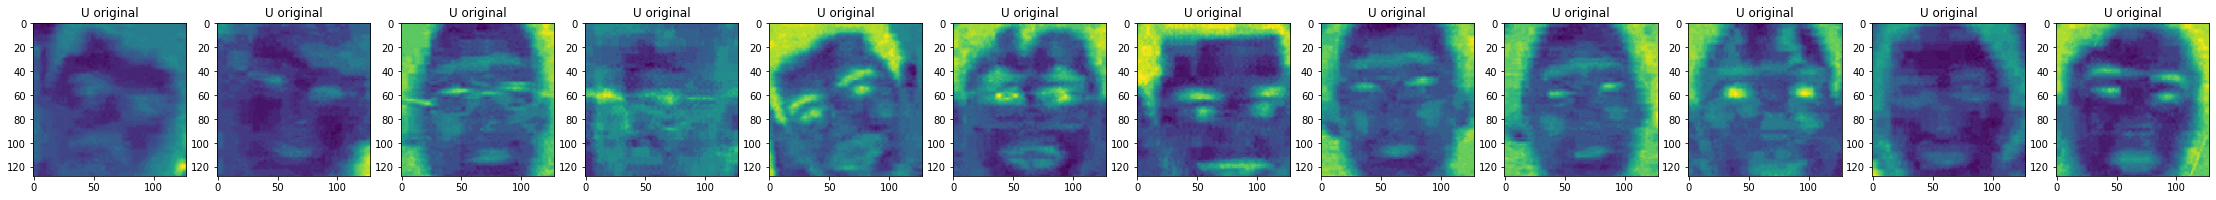

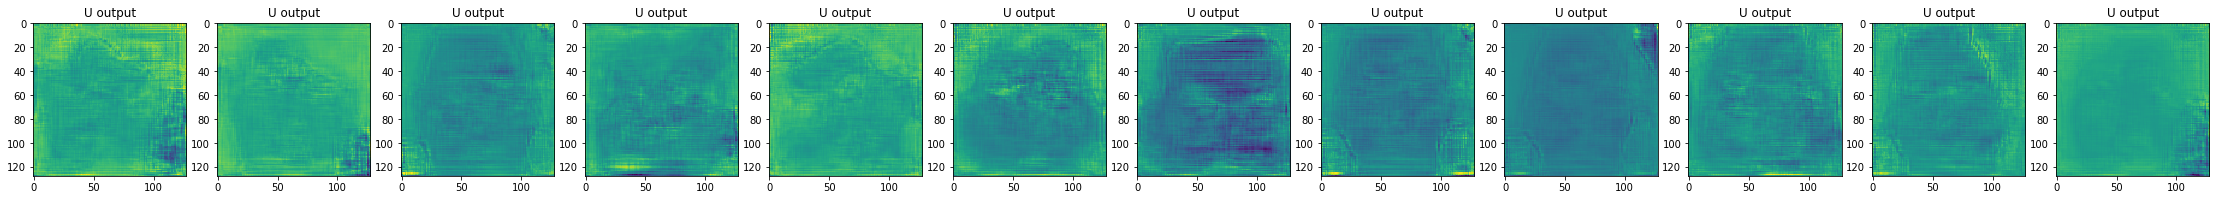

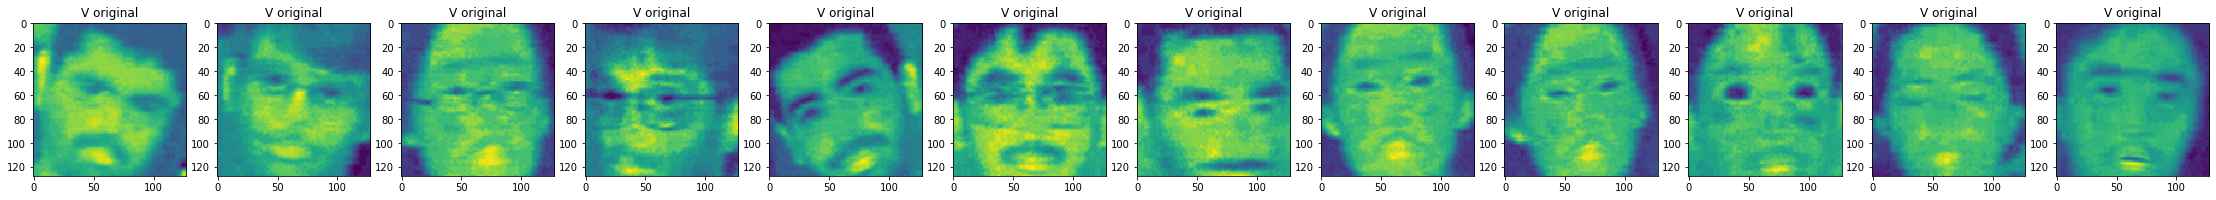

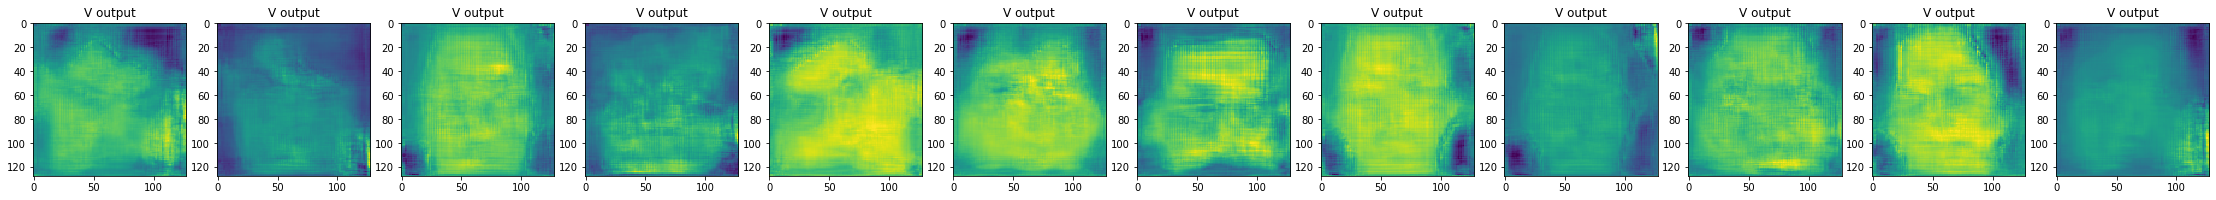

In [17]:
output = gan.generate_uv_images(train_y)
result = np.zeros((train_y.shape[0], 128, 128, 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[TRAINING_IMAGE+i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TRAINING_IMAGE+i]))
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,2])

# Testing Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

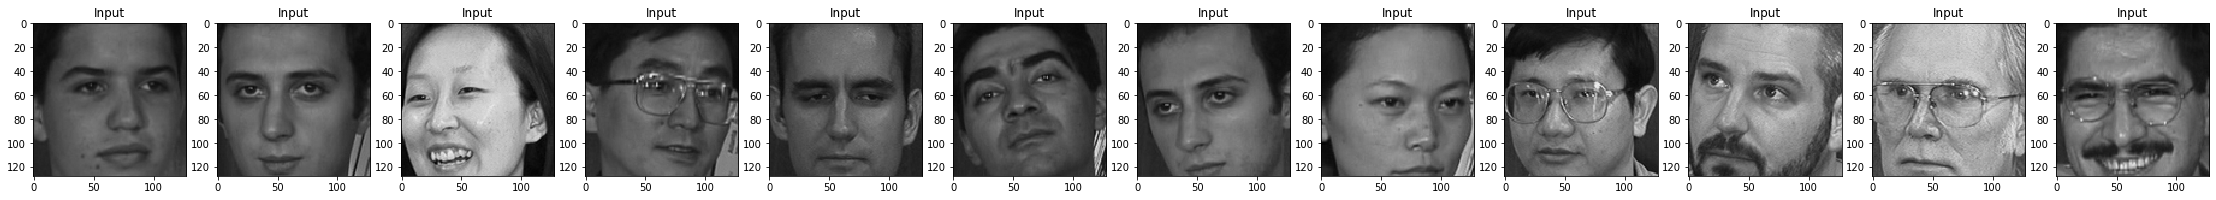

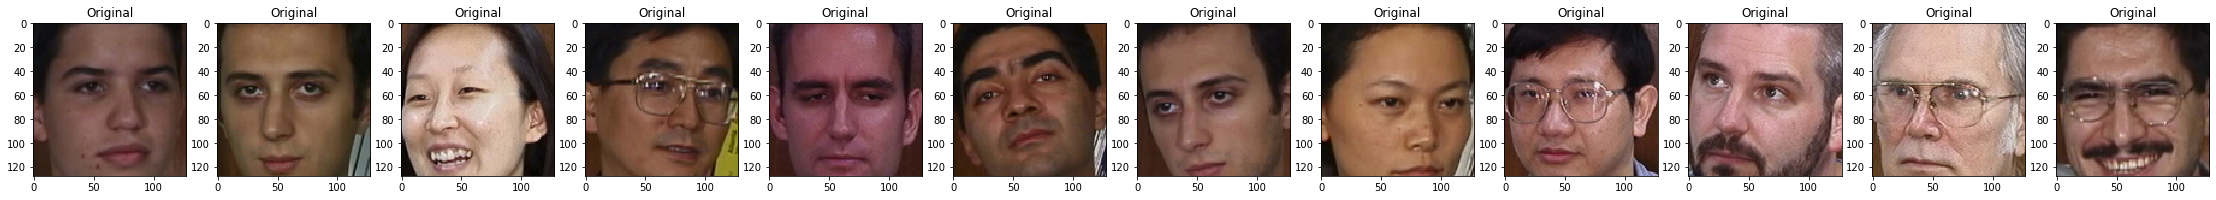

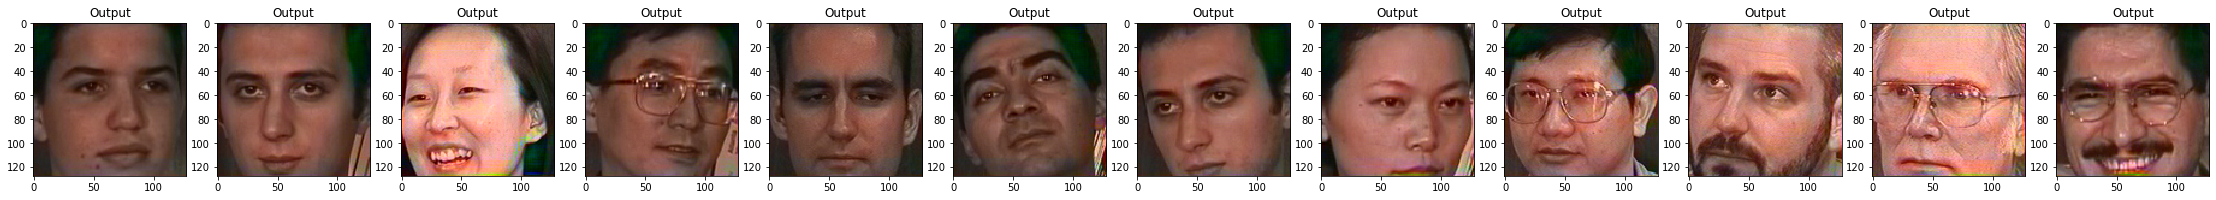

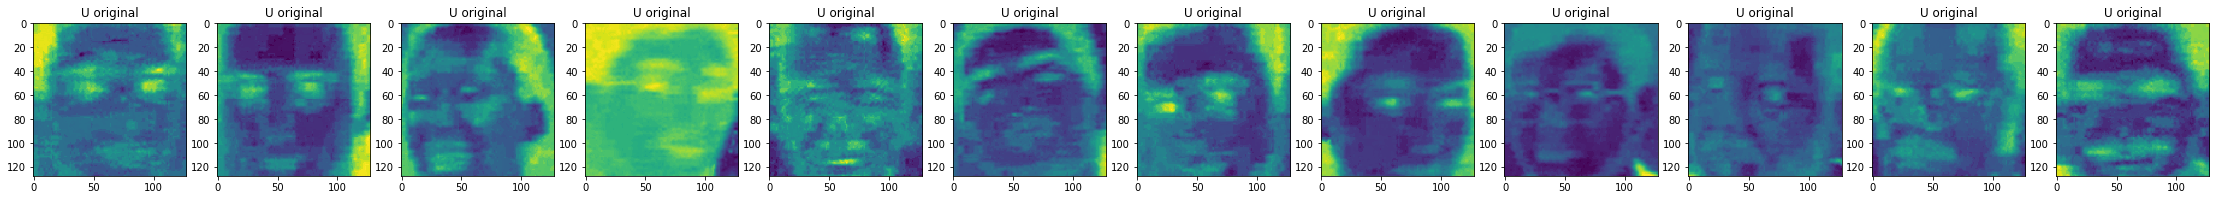

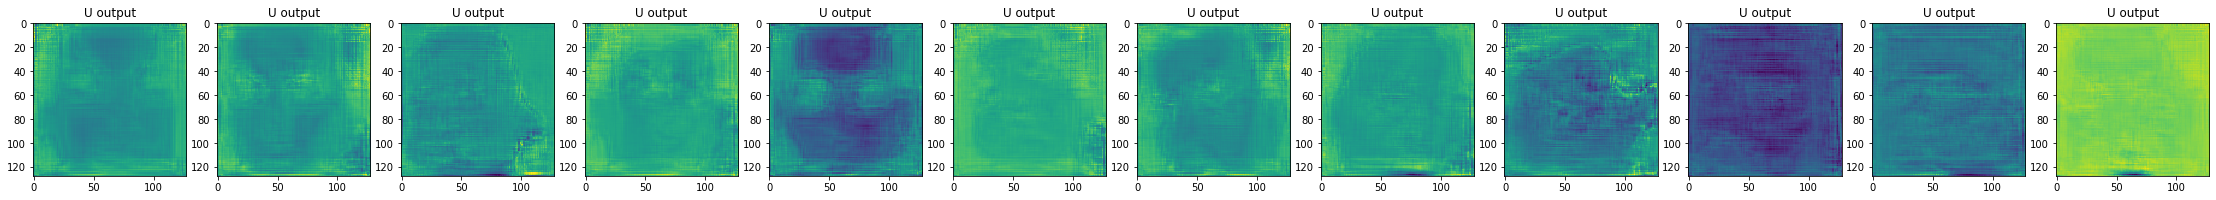

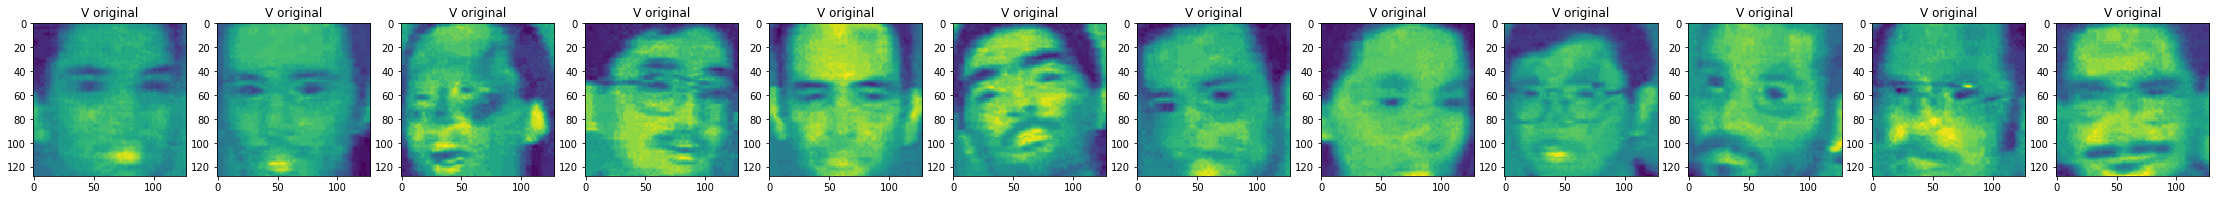

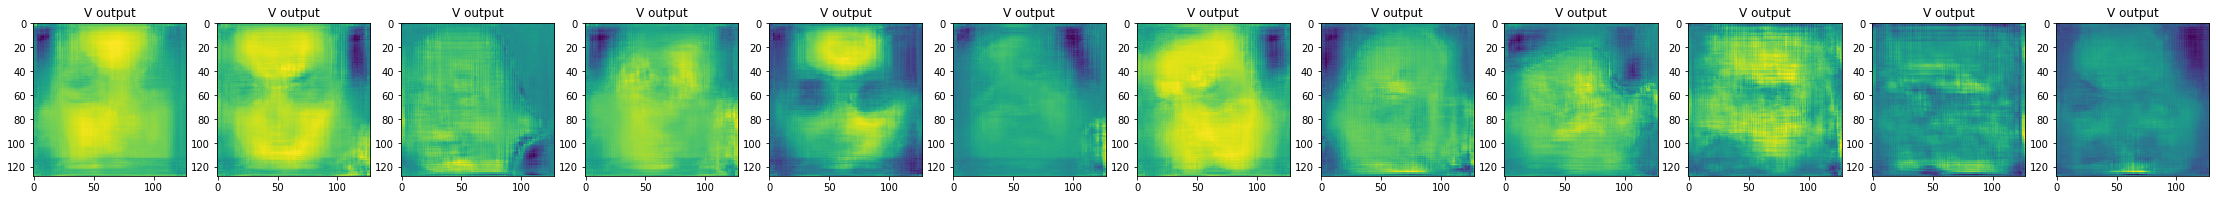

In [19]:
output = gan.generate_uv_images(test_y)
result = np.zeros((test_y.shape[0], 128, 128, 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
output_count = 12

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i]))

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(test_images[TEST_IMAGE+i])

fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TEST_IMAGE+i]))
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(39, 39))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TEST_IMAGE+i,:,:,2])